# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

## Question 1:
In this question we train a linearly separable data with multi layer perceptron

### import libraries

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns

### check GPU availability

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### create data

In [18]:
x, y = datasets.make_blobs(n_samples=200, centers=[(-1, -1), (1, 1)], cluster_std=0.5)
# convert to the torch tensor
x = torch.tensor(x, dtype=torch.float32, device=device)
y = torch.tensor(y, dtype=torch.float32, device=device)

### plot data

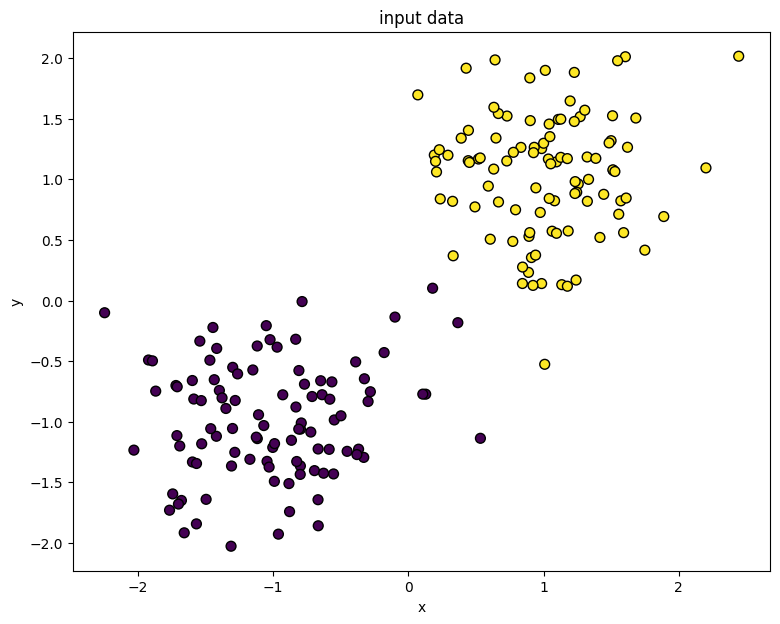

In [19]:
plt.figure(figsize=(9, 7))
plt.scatter(x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), c=y.cpu().numpy(), edgecolors='k', marker='o', s=50)
plt.title("input data")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### define MLP class with this structure:
* 4 layer neurons (input + hidden1 + hidden2 + output)
* input layer neurons: 2
* hidden1 layer neurons: 10
* hidden2 layer neurons: 10
* output layer neurons: 2
* activation function in each layer: sigmoid

In [20]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(2, 10)
        self.hidden2 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, x):
        x = F.sigmoid(self.hidden1(x))
        x = F.sigmoid(self.hidden2(x))
        x = self.output(x)
        return F.softmax(x, dim=1)

### set network parameters

In [21]:
model = MLP().to(device)

# set adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# set binary cross entropy for loss function
criterion = nn.CrossEntropyLoss()
print("Network parameter:\n ", model)

epochs = 50

Network parameter:
  MLP(
  (hidden1): Linear(in_features=2, out_features=10, bias=True)
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=2, bias=True)
)


### train phase

In [23]:
loss_values = []
accuracy_values = []

for epoch in range(epochs):
    outputs = model(x) # forward pass
    loss = criterion(outputs, y.long()) # compute loss
    
    # backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item()) # save loss value
    
    # compute accuracy
    _, predicted = torch.max(outputs.data, 1)
    total = y.size(0)
    correct = (predicted == y.long()).sum().item()
    accuracy = correct / total

    accuracy_values.append(accuracy) # save accuracy value
    
    if ((epoch+1) % 5 == 0):
        print ("Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}".format(epoch+1, epochs, loss.item(), accuracy))


Epoch [5/50], Loss: 0.3384, Accuracy: 0.99
Epoch [10/50], Loss: 0.3322, Accuracy: 0.99
Epoch [15/50], Loss: 0.3285, Accuracy: 0.99
Epoch [20/50], Loss: 0.3261, Accuracy: 1.00
Epoch [25/50], Loss: 0.3245, Accuracy: 1.00
Epoch [30/50], Loss: 0.3233, Accuracy: 1.00
Epoch [35/50], Loss: 0.3224, Accuracy: 1.00


Epoch [40/50], Loss: 0.3216, Accuracy: 1.00
Epoch [45/50], Loss: 0.3210, Accuracy: 1.00
Epoch [50/50], Loss: 0.3205, Accuracy: 1.00


### plot results

plot loss and accuracy

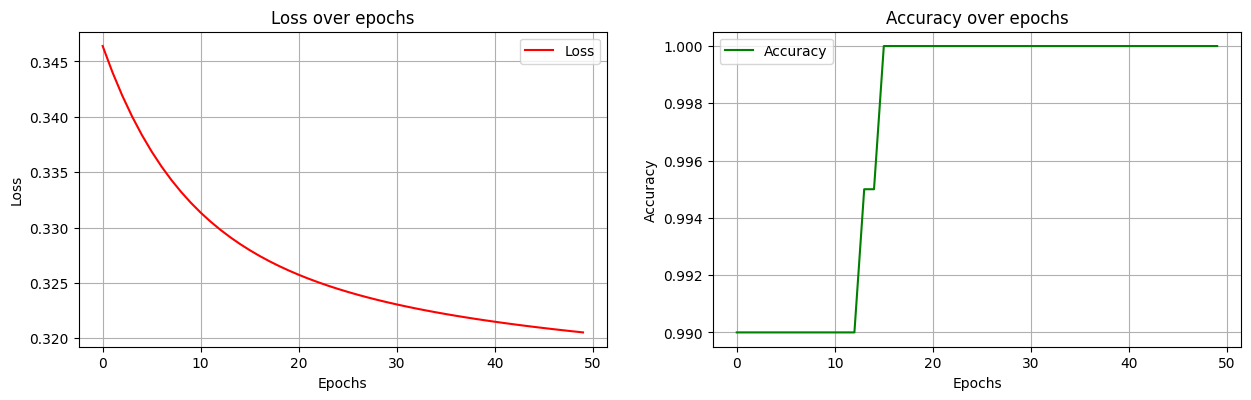

In [24]:
plt.figure(figsize=(15, 9))

# plot loss
plt.subplot(2, 2, 1)
plt.plot(loss_values, label="Loss", color="red")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# plot accuracy
plt.subplot(2, 2, 2)
plt.plot(accuracy_values, label="Accuracy", color="green")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plot confusion matrix

Text(83.22222222222221, 0.5, 'True class')

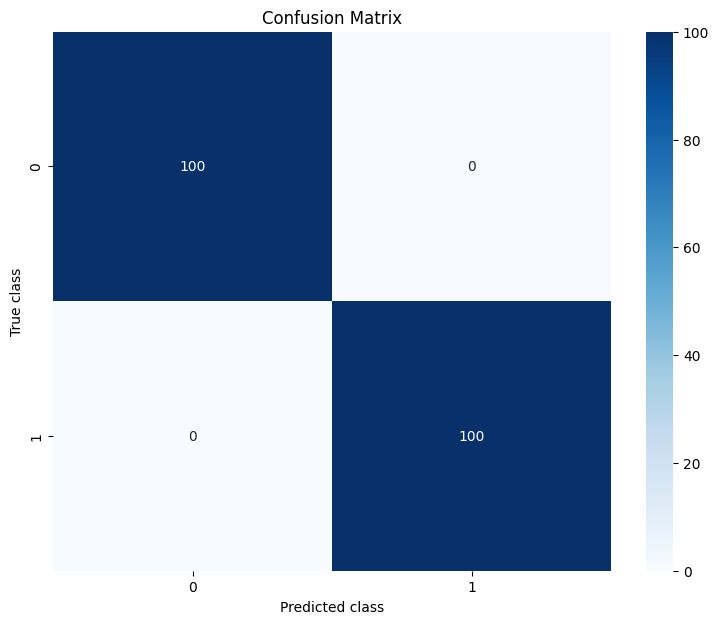

In [25]:
# compute confusion matrix
_, predicted = torch.max(model(x).data, 1)
cm = confusion_matrix(y.cpu().numpy(), predicted.cpu().numpy())

# plot confusion matrix
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class")

plot the decision boundary

Text(0, 0.5, 'y')

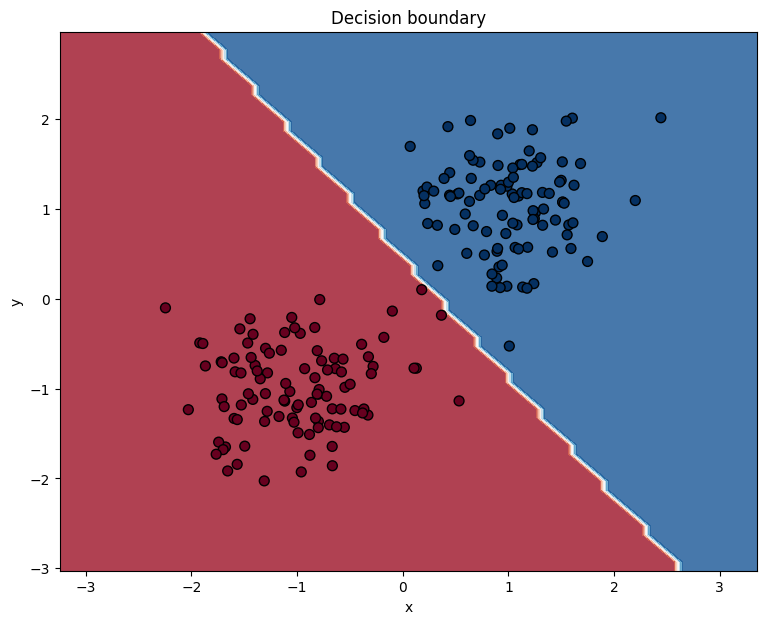

In [26]:
# make grid of points for coloring
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min.item(), x_max.item(), 0.1),
                     np.arange(y_min.item(), y_max.item(), 0.1))

# predict the class for each point
grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
preds = model(grid)
_, predicted = torch.max(preds.data, 1)

# reshape the predicted classes to have the same shape as xx
Z = predicted.cpu().numpy().reshape(xx.shape)

# plot the decision boundary
plt.figure(figsize=(9, 7))
plt.contourf(xx, yy, Z, alpha=0.8, cmap="RdBu")
plt.scatter(x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), c=y.cpu().numpy(), cmap="RdBu", edgecolors='k', marker='o', s=50)
plt.title("Decision boundary")
plt.xlabel('x')
plt.ylabel('y')